In [1]:
using Population
using Plots
using Statistics
using Distributions
using LaTeXStrings

In [2]:
N = 10.0
mu = 20.0
mu2 = 20.0
sd = 10.0

xr = 0:50

function simDet(hazard::HazTypes)
    pop = sPop2(PopDataDet())
    AddProcess(pop, hazard)
    AddPop(pop, N)
    retd = [0 N 0.0]
    for n in xr[2:end]
        pr1 = typeof(hazard) <: AgeConst ? (prob=(mu != mu2 && n > 20) ? 1.0/mu2 : 1.0/mu,) : (devmn=(mu != mu2 && n > 20) ? mu2 : mu, devsd=sd)
        ret = StepPop(pop, pr1)
        retd = vcat(retd, [n ret[1] ret[2]])
    end
    return retd
end

function simStoch(hazard::HazTypes)
    pop = sPop2(PopDataSto())
    AddProcess(pop, hazard)
    rets = []
    for r in 1:1000
        AddPop(pop, Int64(N))
        ret = [Int64(N)]
        for n in xr[2:end]
            pr1 = typeof(hazard) <: AgeConst ? (prob=(mu != mu2 && n > 20) ? 1.0/mu2 : 1.0/mu,) : (devmn=(mu != mu2 && n > 20) ? mu2 : mu, devsd=sd)
            sz = StepPop(pop, pr1)
            push!(ret, sz[1])
        end
        if rets == []
            rets = ret
        else
            rets = cat(rets,ret,dims=2)
        end
        EmptyPop(pop)
    end
    res = []
    for r in 1:size(rets)[1]
        p = quantile(rets[r,:],[0.05,0.5,0.95])
        if res == []
            res = p
        else
            res = hcat(res, p)
        end
    end
    return hcat(xr,transpose(res))
end

simStoch (generic function with 1 method)

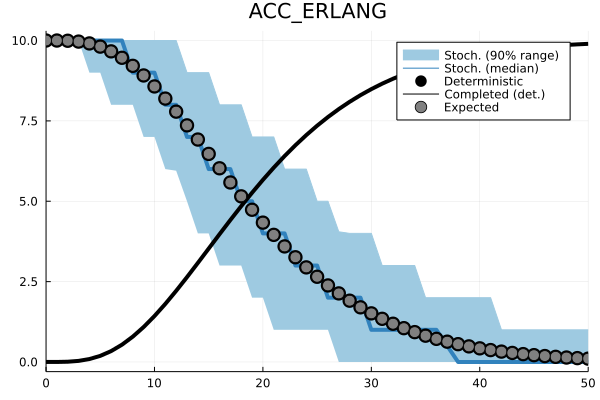

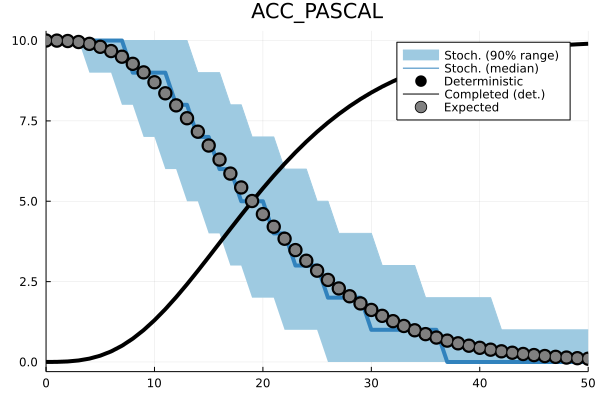

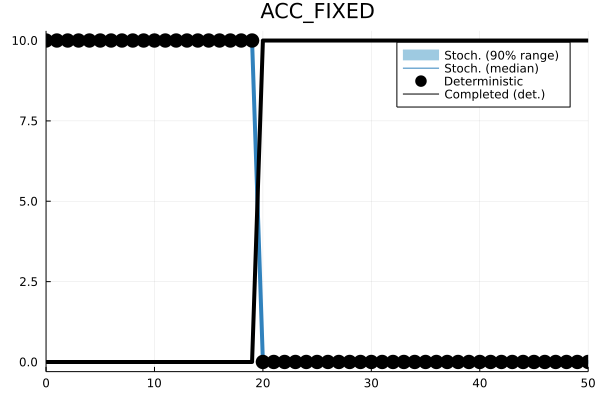

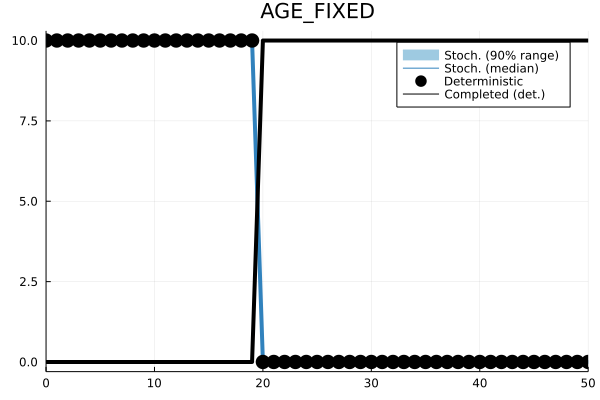

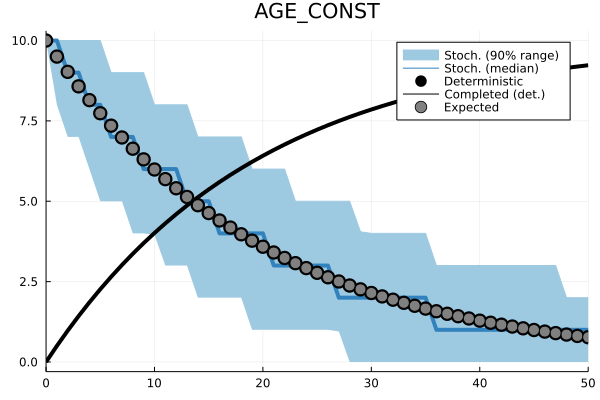

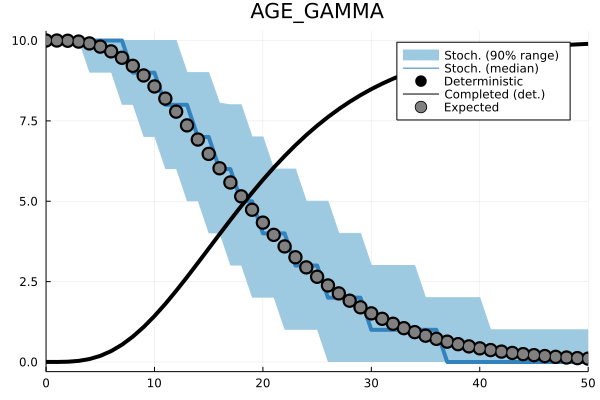

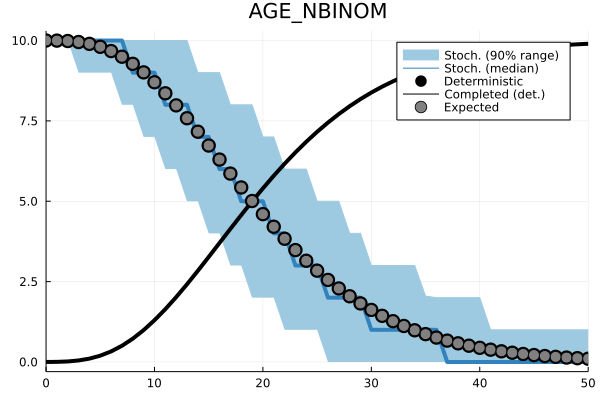

In [4]:
hazards = ["ACC_ERLANG", "ACC_PASCAL", "ACC_FIXED", "AGE_FIXED", "AGE_CONST", "AGE_GAMMA", "AGE_NBINOM"]
for hazard in hazards
    if hazard == "ACC_ERLANG"
        hz = AccErlang()
        pr1 = (devmn=mu,devsd=sd)
    elseif hazard == "ACC_PASCAL"
        hz = AccPascal()
        pr1 = (devmn=mu,devsd=sd)
    elseif hazard == "ACC_FIXED"
        hz = AccFixed()
        pr1 = (devmn=mu,)
    elseif hazard == "AGE_FIXED"
        hz = AgeFixed()
        pr1 = (devmn=mu,)
    elseif hazard == "AGE_CONST"
        hz = AgeConst()
        pr1 = (prob=1.0/mu,)
    elseif hazard == "AGE_GAMMA"
        hz = AgeGamma()
        pr1 = (devmn=mu,devsd=sd)
    elseif hazard == "AGE_NBINOM"
        hz = AgeNbinom()
        pr1 = (devmn=mu,devsd=sd)
    end
    out_det = simDet(hz)
    out_sto = simStoch(hz)
    k, theta, stay = hz.pars(pr1)
    plot(out_sto[:,1], out_sto[:,4], fillrange = out_sto[:,2], title=hazard, c="#9ecae1", label="Stoch. (90% range)")
    plot!(out_sto[:,1], out_sto[:,3], lw=4, c="#3182bd", label="Stoch. (median)")
    plot!(out_det[:,1], out_det[:,2], line = :scatter, c="black", ms=8, label="Deterministic")
    plot!(out_det[:,1], cumsum(out_det[:,3]), c="black", lw=4, label="Completed (det.)")
    if hazard in ["ACC_ERLANG" "AGE_GAMMA"]
        plot!(xr, N*(1.0 .- cdf(Gamma(k,theta),xr)), line= :scatter, c="gray", ms=6, label="Expected")
    elseif hazard in ["ACC_PASCAL" "AGE_NBINOM"]
        plot!(xr, N*(1.0 .- cdf(NegativeBinomial(k,theta),xr .- 1)), line= :scatter, c="gray", ms=6, label="Expected")
    elseif hazard in ["AGE_CONST"]
        plot!(xr, [N*(1.0 .- cdf(Geometric(theta),x-1)) for x in xr], line= :scatter, c="gray", ms=6, label="Expected")
    end
    display(xlims!(0,50))
end

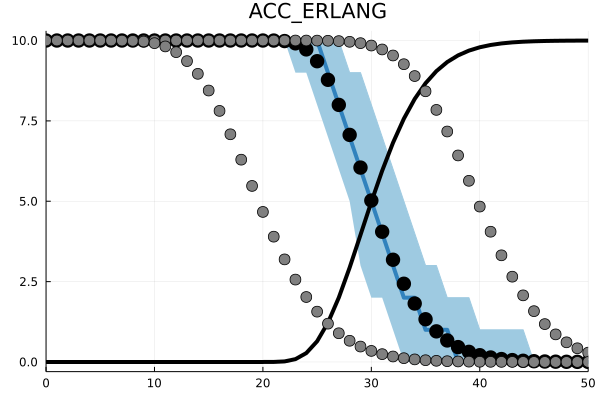

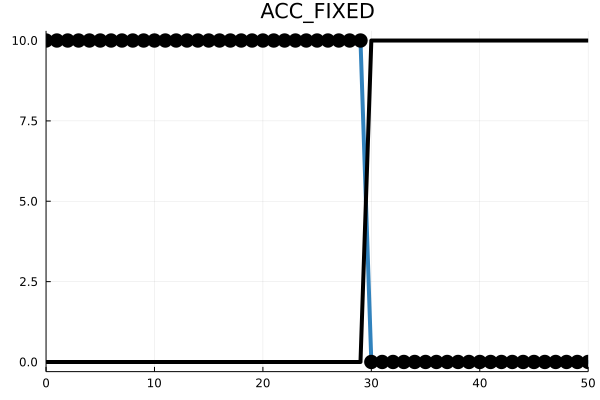

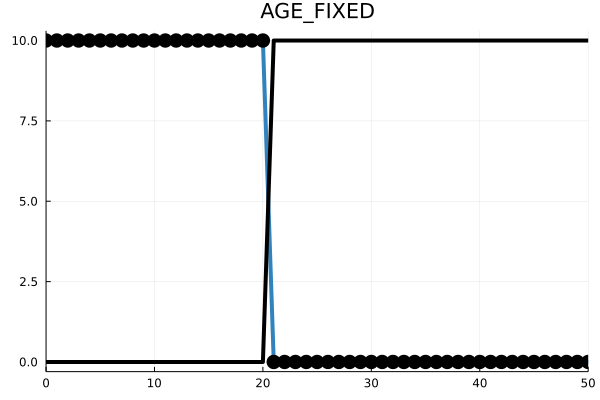

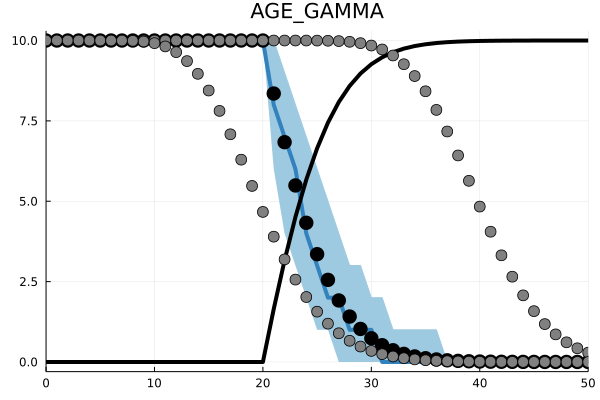

In [5]:
mu = 40.0
mu2 = 20.0
sd = 5.0
pr1 = (devmn=mu,devsd=sd)
pr2 = (devmn=mu2,devsd=sd)

hazards = ["ACC_ERLANG", "ACC_FIXED", "AGE_FIXED", "AGE_GAMMA"]
for hazard in hazards
    if hazard == "ACC_ERLANG"
        hz = AccErlang()
    elseif hazard == "ACC_FIXED"
        hz = AccFixed()
    elseif hazard == "AGE_FIXED"
        hz = AgeFixed()
    elseif hazard == "AGE_GAMMA"
        hz = AgeGamma()
    end
    out_det = simDet(hz)
    out_sto = simStoch(hz)
    k1, theta1, stay1 = hz.pars(pr1)
    k2, theta2, stay2 = hz.pars(pr2)
    plot(out_sto[:,1], out_sto[:,4], fillrange = out_sto[:,2], title=hazard, c="#9ecae1", label=:none)
    plot!(out_sto[:,1], out_sto[:,3], lw=4, c="#3182bd", label=:none)
    plot!(out_det[:,1], out_det[:,2], line = :scatter, c="black", ms=8, label=:none)
    plot!(out_det[:,1], cumsum(out_det[:,3]), c="black", lw=4, label=:none)
    if hazard in ["ACC_ERLANG" "AGE_GAMMA"]
        plot!(xr, N*(1.0 .- cdf(Gamma(k1,theta1),xr)), line= :scatter, c="gray", ms=6, label=:none)
        plot!(xr, N*(1.0 .- cdf(Gamma(k2,theta2),xr)), line= :scatter, c="gray", ms=6, label=:none)
    elseif hazard in ["ACC_PASCAL" "AGE_NBINOM"]
        plot!(xr, N*(1.0 .- cdf(NegativeBinomial(k1,theta1),xr .- 1)), line= :scatter, c="gray", ms=6, label=:none)
        plot!(xr, N*(1.0 .- cdf(NegativeBinomial(k2,theta2),xr .- 1)), line= :scatter, c="gray", ms=6, label=:none)
    end
    display(xlims!(0,50))
end

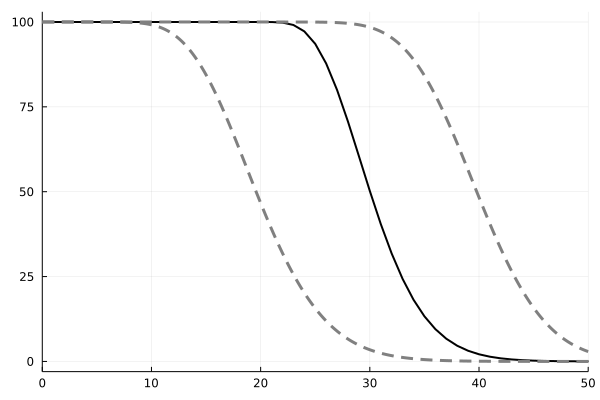

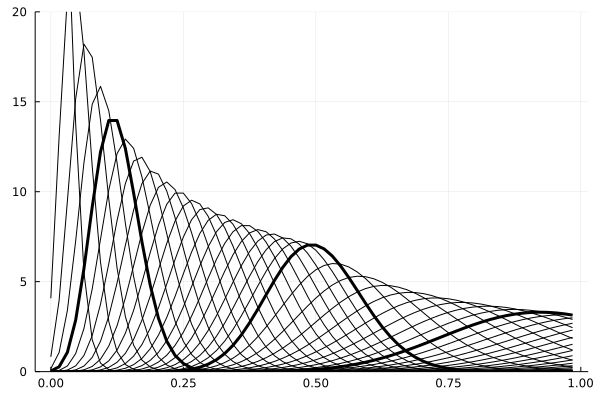

In [5]:
mu = [40.0 20.0]
sd = [5.0 5.0]
theta = sd .* sd ./ mu
k = mu ./ theta

xri = collect(0:199)
xr = collect(0:0.01:50)

a = sPop2(PopDataDet())
AddProcess(a, AccErlang())
AddPop(a, 100.0)

ii = [0 1]
retA = [0 GetPop(a)]
retL = [0 GetPoptable(a)]
for n in xri[2:end]
    i = n<=20 ? 1 : 2
    pr = (devmn=mu[i], devsd=sd[i])
    StepPop(a, pr)
    retA = vcat(retA, [n GetPop(a)])
    retL = vcat(retL, [n GetPoptable(a)])
    ii = vcat(ii,[n i])
end

plot(xri,retA[:,2], c="black", lw=2, legend=false)
for i in [2 1]
    plot!(xr,100*(1.0 .- cdf(Gamma(k[i],theta[i]), xr)), c="gray", lw=3, ls=:dash, legend=false)
end
display(xlims!((0, 50)))

plot(retL[1,2], c="black", legend = false)
for r in 2:50
    plot!(retL[r,2], c="black", lw=retL[r,1] in [5 20 29] ? 3 : 1, legend = false)
end
display(ylims!((0,20)))

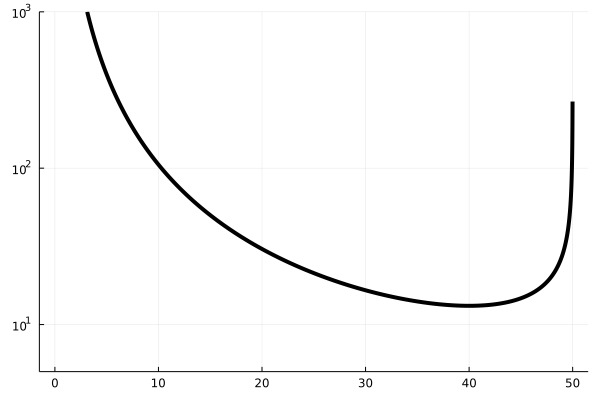

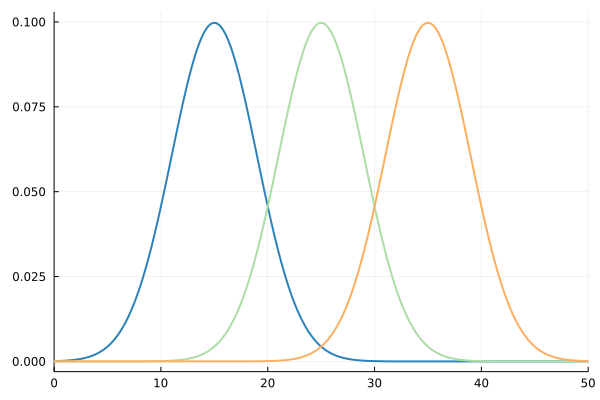

In [6]:
temp = [15 25 35]
labels = Dict(15=>L"\rho_L", 25=>L"\rho_M", 35=>L"\rho_H")
clscl = Dict(15=>"#2b83ba", 25=>"#abdda4", 35=>"#fdae61")

function briere1(T,T1,T2,a); return a*T*(T-T1)*sqrt(T2-T); end

xr = collect(0:0.01:50)
yr = [1/briere1(x,0,50,1.5e-5) for x in xr]

plot(xr, yr, yaxis=:log, lw=4, c="black", legend=false)
display(ylims!(5,1e3))

plot([0 50],[0 0.1],legend=false)
for i in 1:3
    N = Normal(temp[i],4)
    plot!(xr,[pdf(N,x) for x in xr], c=clscl[temp[i]], lw=2)
end
display(xlims!(0,50))

Without noise, EPS test, t=15, e=4


Without noise, EPS test, t=15, e=3


Without noise, EPS test, t=15, e=2


Without noise, EPS test, t=15, e=1


Without noise, EPS test, t=25, e=4


Without noise, EPS test, t=25, e=3


Without noise, EPS test, t=25, e=2


Without noise, EPS test, t=25, e=1


Without noise, EPS test, t=35, e=4


Without noise, EPS test, t=35, e=3


Without noise, EPS test, t=35, e=2


Without noise, EPS test, t=35, e=1


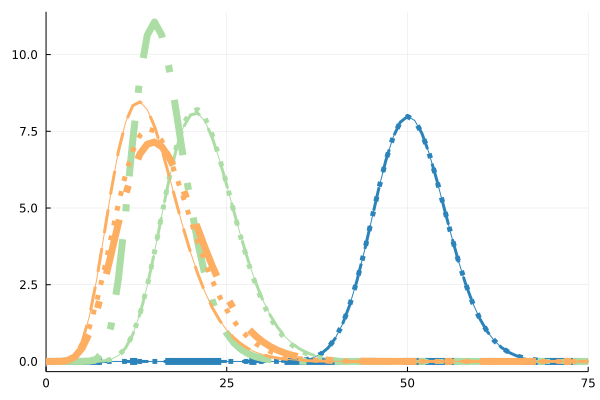

In [7]:
function var_temp(mu, sd)
    if sd == 0.0; return mu; end
    y = rand(Normal(mu, sd))
    y = min(50.0, max(0.0, y))
    return y
end

function dev_time(temp)
    y = briere1(temp, 0, 50, 1.5e-5)
    if y == 0; return 1e3; end
    return 1.0 / y
end

function sim(mu, sd, rep=1, eps=4, verbose=0)
    set_acc_eps(eps)
    rets = []
    for r in 1:rep
        if verbose == 1
            println("Rep ", r); flush(stdout)
        end
        a = sPop2(PopDataDet())
        AddProcess(a, AccErlang())
        AddPop(a,100.0)
        ret = [0 NaN GetPop(a) 0.0]
        for i in 0:100
            temp = var_temp(mu, sd)
            dev = dev_time(temp)
            pr = (devmn=dev, devsd=5.0)
            out = StepPop(a, pr)
            ret = vcat(ret, [i+1 dev out[1] out[2]])
            if verbose == 2
                println("Step ", r, " ", i); flush(stdout)
            end
        end
        if rets == []
            rets = ret
        else
            rets = cat(rets, ret, dims=3)
        end
    end
    set_acc_eps(0)
    tmp = [0.0; 0.0; 0.0; 0.0]
    for i in 1:size(rets)[1]
        tmp = hcat(tmp, vcat(rets[i,1,1],quantile(rets[i,4,:],[0.05,0.5,0.95])))
    end
    tmp = transpose(tmp[:,2:end])
    return tmp
end

plot([0 100], [0 10], label=:none)
for t in temp
    for e in 4:-1:1
        println("Without noise, EPS test, t=",t,", e=",e); flush(stdout)
        s = sim(t, 0.0, 1, e, false)
        plot!(s[:,1],s[:,4], c=clscl[t], lw=2*(4-e)+1, ls=[:dashdot :dot :dash :solid][e], label=:none)
    end
end
display(xlims!(0,75))

Without noise, t=15
Without noise, t=25
Without noise, t=35
With noise, t=15
With noise, t=25
With noise, t=35


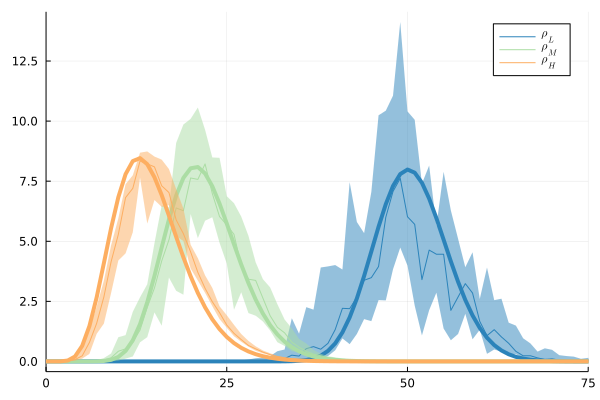

In [8]:
dets = Dict()
for t in temp
    println("Without noise, t=",t); flush(stdout)
    dets[t] = sim(t, 0.0, 1, 3, false)
end

detst = Dict()
for t in temp
    println("With noise, t=",t); flush(stdout)
    detst[t] = sim(t, 4.0, 10, 3, false)
end

plot([0 100], [0 10], label=:none)
for t in temp
    plot!(detst[t][:,1],detst[t][:,4], fillrange=detst[t][:,2], lw=0, fillcolor=clscl[t], alpha=0.5, label=:none)
    plot!(detst[t][:,1],detst[t][:,3], c=clscl[t], lw=1, label=:none)
    plot!(dets[t][:,1],dets[t][:,4], c=clscl[t], lw=4, label=labels[t])
end
display(xlims!(0,75))

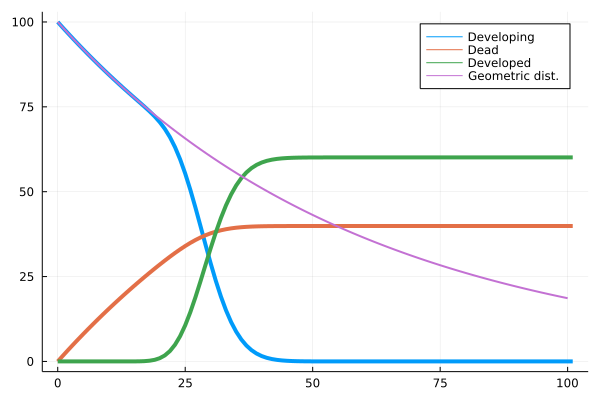

In [8]:
a = sPop2(PopDataDet())
AddProcess(a, AgeConst(), AccErlang())
AddPop(a,100.0)
ret = [0 GetPop(a) 0.0 0.0]
for i in 0:100
    pr1 = (prob=1.0/60.0,)
    pr2 = (devmn=30.0, devsd=5.0)
    out = StepPop(a, pr1, pr2)
    ret = vcat(ret, [i+1 out[1] out[2][1] out[2][2]])
end

xr = 0:100
plot(ret[:,1],ret[:,2],lw=4,label="Developing")
plot!(ret[:,1],cumsum(ret[:,3]),lw=4,label="Dead")
plot!(ret[:,1],cumsum(ret[:,4]),lw=4,label="Developed")
plot!(xr,[100.0*(1 .- cdf(Geometric(1.0/60.0),x-1)) for x in xr], lw=2, label="Geometric dist.")

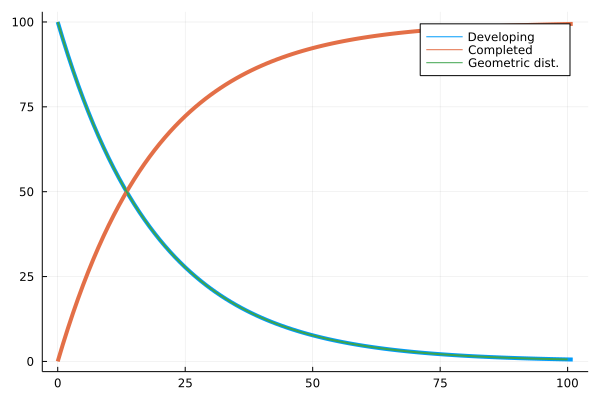

In [9]:
function custom(heval::Function, d::Number, q::Number, k::Number, theta::Number, qkey::Tuple)
    Float64(1.0/20.0)
end

a = sPop2(PopDataDet())
AddProcess(a, AgeCustom(custom))
AddPop(a,100.0)
ret = [0 GetPop(a) 0.0]
for i in 0:100
    pr1 = NamedTuple{}()
    out = StepPop(a, pr1)
    ret = vcat(ret, [i+1 out[1] out[2][1]])
end

xr = 0:100
plot(ret[:,1],ret[:,2],lw=4,label="Developing")
plot!(ret[:,1],cumsum(ret[:,3]),lw=4,label="Completed")
plot!(xr,[100.0*(1 .- cdf(Geometric(1.0/20.0),x-1)) for x in xr], lw=2, label="Geometric dist.")

In [10]:
function custom(heval::Function, d::Number, q::Number, k::Number, theta::Number, qkey::Tuple)
    devmn = 480.0 - (qkey[3] > 4 ? 240.0 : 48.0 * qkey[3])
    devsd = 0.1 * devmn
    pr = (devmn=devmn, devsd=devsd)
    k, theta, stay = sPop2.age_gamma_pars(pr)
    return sPop2.age_hazard_calc(sPop2.age_gamma_haz, 0, qkey[1], k, theta, qkey)
end

function SimDet()
    a = sPop2(PopDataDet())
    # Mortality, Gonotropic cycle, Ovipositioning
    AddProcess(a, AgeCustom(custom,AgeStepper), AgeGamma(), AgeDummy())
    AddPop(a,1000.0)
    ret = [0 0.0]
    for i in 0:480
        pr1 = NamedTuple{}()
        pr2 = (devmn=50.0, devsd=10.0)
        out = StepPop(a, pr1, pr2, pr1)
        for (q,n) in out[3][2]
            AddPop(a, n, q.key[1]+one(q.key[1]), 0, q.key[3]+one(q.key[3]))
        end
        ret = vcat(ret, [i+1 out[2][2]])
    end
    return ret
end

function SimSto()
    a = sPop2(PopDataSto())
    # Mortality, Gonotropic cycle, Ovipositioning
    AddProcess(a, AgeCustom(custom,AgeStepper), AgeGamma(), AgeDummy())
    rets = []
    for r in 1:100
        AddPop(a,1000)
        ret = [0 0]
        for i in 0:480
            pr1 = NamedTuple{}()
            pr2 = (devmn=50.0, devsd=10.0)
            out = StepPop(a, pr1, pr2, pr1)
            for (q,n) in out[3][2]
                AddPop(a, n, q.key[1], 0, q.key[3]+one(q.key[3]))
            end
            ret = vcat(ret, [i+1 out[2][2]])
        end
        EmptyPop(a)
        if rets == []
            rets = ret
        else
            rets = cat(rets, ret, dims=3)
        end
    end
    tmp = [0.0; 0.0; 0.0; 0.0]
    for i in 1:size(rets)[1]
        tmp = hcat(tmp, vcat(rets[i,1,1],quantile(rets[i,2,:],[0.05,0.5,0.95])))
    end
    tmp = transpose(tmp[:,2:end])
    return tmp
end

SimSto (generic function with 1 method)

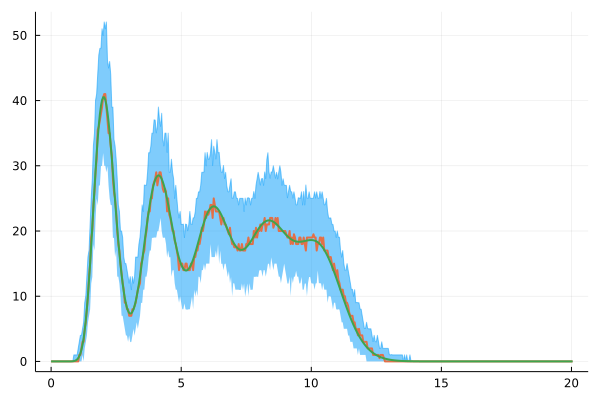

In [21]:
retd = SimDet()
rets = SimSto()

plot(rets[:,1]/24.0,rets[:,4],fillrange=rets[:,2], lw=1, alpha=0.5, label=:none)
plot!(rets[:,1]/24.0,rets[:,3], lw=2, label=:none)
plot!(retd[:,1]/24.0,retd[:,2], lw=2, label=:none)